In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ! unzip /content/drive/MyDrive/Data/train_images.zip -d /content/drive/MyDrive/Data/new_train

In [ ]:
# !pip install timm
!pip install deepspeed mpi4py
!pip install pytorch-lightning
!pip install albumentations

     |████████████████████████████████| 556 kB 14.8 MB/s 
     |████████████████████████████████| 2.5 MB 62.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 54 kB 3.4 MB/s 
     |████████████████████████████████| 108 kB 97.7 MB/s 
     |████████████████████████████████| 99 kB 12.8 MB/s 
  Created wheel for deepspeed: filename=deepspeed-0.6.4-py3-none-any.whl size=556302 sha256=f1085ce80d51ca29781890211317d524294cee6d2133eaeee262f789f5d8aa76
  Stored in directory: /root/.cache/pip/wheels/d9/51/5a/aa1287f4e6ea5f57027e352761c0ae0a7cf0a300f50c45e68c
  Created wheel for mpi4py: filename=mpi4py-3.1.3-cp37-cp37m-linux_x86_64.whl size=2185279 sha256=84fada4252f45f773dfc23730ccbf7d363d22d3cd683fa69ee483715a80e27a7
  Stored in directory: /root/.cache/pip/wheels/7a/07/14/6a0c63fa2c6e473c6edc40985b7d89f05c61ff25ee7f0ad9ac
  Created wheel for py-cpuinfo: filename=py_cpuinfo-8

In [ ]:
# !pip install pytorch_model_summary
import torch
import sys
from PIL import Image, ImageFile
from torch.utils.data import TensorDataset, DataLoader,Dataset, random_split
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
import torchvision.models as models
from collections import OrderedDict
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
from typing import Optional # required for "Optional[type]"

# lightning related imports
import pytorch_lightning as pl
from pytorch_lightning.callbacks import Callback
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint, ModelPruning
from pytorch_lightning.plugins import DeepSpeedPlugin
from torchmetrics import Accuracy

import albumentations as alb

print("PyTorch Lightning Version : {}".format(pl.__version__))

import warnings
warnings.filterwarnings("ignore", message=".*does not have many workers which may be a bottleneck.*")

import os
ImageFile.LOAD_TRUNCATED_IMAGES = True

# import wandb
# wandb.init(reinit=True)

# from kaggle_secrets import UserSecretsClient
# user_secrets = UserSecretsClient()

# personal_key_for_api = user_secrets.get_secret("wandb-key")

# !wandb login $personal_key_for_api

PyTorch Lightning Version : 1.6.3


In [ ]:
# Load Dataset data
import torch
from torch.utils.data import Dataset, DataLoader, Sampler, BatchSampler
from torchvision.transforms import Compose
import os
import h5py


train_f = h5py.File('/content/drive/MyDrive/Data/Final_Train_XY_380.h5', 'r')
input_train = train_f['image_out']
label_train = train_f['label_out']

In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/Data/Final_Train_XY.csv', encoding='utf-8')

In [ ]:
class ImageLabelDataset(Dataset):
    def __init__(self, df_data, prediction, isTrain=True):
        super().__init__()
        self.df = df_data
        self.prediction = prediction
        self.isTrain = isTrain

    def __len__(self):
        return len(self.df)
    
    @property
    def train_labels(self):
        # warnings.warn("train_labels has been renamed targets")
        return self.prediction
    
    def __getitem__(self, index):
        label = self.prediction[index]
        label_tensor = int(label)
        # label_tensor = torch.tensor(label, dtype=torch.float32)
        tensorimage = self.preprocess_image(self.df[index])
        return tensorimage, label_tensor
        # return {'image': tensorimage, 'labels': label_tensor}

    def preprocess_image(self, img_path):        
        
        image_transform_train = alb.Compose([
            alb.Resize(p=1.0, width=640, height=480, interpolation=2),
            alb.CenterCrop(p=1.0, width=370, height=370),
            alb.Resize(p=1.0, width=380, height=380, interpolation=3),
            # alb.RandomResizedCrop(299, 299),
            # alb.Transpose(p=0.5),
            alb.HorizontalFlip(p=0.5),
            alb.VerticalFlip(p=0.5),
            alb.ShiftScaleRotate(p=0.5),
            alb.GridDistortion(p=0.5, num_steps=5, distort_limit=(-0.5, 0.5), interpolation=0, border_mode=2),
            # alb.HueSaturationValue(
            #     hue_shift_limit=0.2, 
            #     sat_shift_limit=0.2, 
            #     val_shift_limit=0.2, 
            #     p=0.5
            # ),
            # alb.RandomBrightnessContrast(
            #     brightness_limit=(-0.1,0.1), 
            #     contrast_limit=(-0.1, 0.1), 
            #     p=0.5
            # ),
            alb.Cutout(p=0.5)
        ], p=1.0)
        
        image_transform_test = alb.Compose([
            alb.Resize(p=1.0, width=640, height=480, interpolation=2),
            alb.CenterCrop(p=1.0, width=370, height=370),
            alb.Resize(p=1.0, width=380, height=380, interpolation=3),
        ], p=1.0)
        
        preprocess = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        
        folder = 'data/All_images'        
        image = Image.open("{}/{}".format(folder, img_path))
            
        if(self.isTrain):
            transform_image = image_transform_train(image=np.array(image))['image']
            return preprocess(transform_image)
        else:
            transform_image = image_transform_test(image=np.array(image))['image']
            return preprocess(transform_image)
    
    def get_dummies(self, attribute_id):
        label_tensor = torch.zeros((1, 102))
        label_tensor[0, int(attribute_id)-1] = 1
        return label_tensor

In [ ]:
train_dataset = ImageLabelDataset(df_data=df_train["image_file"].values, prediction=df_train["label"].values)

train_loader = DataLoader(train_dataset, batch_size=2, num_workers=4, shuffle=True)

In [ ]:
dataloader_iterator = iter(train_loader)
x, y = next(dataloader_iterator)
print(x.shape)
print(y.shape)

In [ ]:
train_f.keys()

<KeysViewHDF5 ['image_out', 'label_out']>

In [ ]:
train_f.keys()
data = train_f["image_out"]
label = train_f["label_out"]
input = dict(file=train_f, data=data, label=label)

In [ ]:
input['label'][5]

3.0

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, Sampler, BatchSampler
from torchvision.transforms import Compose
import os
import h5py

class HDDataset(Dataset):
    """Dataset to load data from the Oxford pet dataset .h5 files
    :param dir_path: path to directory containing data (e.g. train, test or val)
    :type dir_path: str
    :param tasks: list of tasks to load data for, must be in 'class', 'seg' or 'bb'
    :type tasks: list
    :param transform: transformation to apply to the images
    :type transform: list
    :param target_transforms: transforms to add to each target, of the form {task:[transforms]}
    :type target_transforms: dict
    :param shuffle: parameter to enable shuffling within batch after loading
    :type shuffle: bool
    :param max_size: maximum size of data to draw from (useful for debugging purposes)
    :type max_size: int
    """
    task_to_file = {
        'class': 'binary.h5',
        'seg': 'masks.h5',
        'bb': 'bboxes.h5'
    }
    def __init__(self, file_path, max_size=None, isTrain=True):

        super(HDDataset, self).__init__()

        self.dir_path = file_path
        self.inputs = self._load_h5_file_with_data()
        self.isTrain = isTrain
        self.max_size = max_size

    def __getitem__(self, index):
        inputs = self.inputs['data'][index]
        tensorimage = self.preprocess_image(inputs)
        label = self.inputs['label'][index]
        label_tensor = int(label)
        return (tensorimage, label_tensor)

    def __len__(self):
        return self.max_size if self.max_size else self.inputs['data'].shape[0]

    def _load_h5_file_with_data(self):
        file = h5py.File(self.dir_path)
        data = train_f["image_out"]
        label = train_f["label_out"]
        return dict(file=file, data=data, label=label)

    def preprocess_image(self, input_img, i_size, label):        
        
        image_transform_train = alb.Compose([
            # alb.Resize(p=1.0, width=2560, height=1920, interpolation=2),
            # alb.CenterCrop(p=1.0, width=1100, height=1100),
            # alb.Resize(p=1.0, width=299, height=299, interpolation=3),
            # alb.RandomResizedCrop(299, 299),
            # alb.Transpose(p=0.5),
            alb.HorizontalFlip(p=0.5),
            alb.VerticalFlip(p=0.5),
            alb.ShiftScaleRotate(p=0.5),
            # alb.HueSaturationValue(
            #     hue_shift_limit=0.2, 
            #     sat_shift_limit=0.2, 
            #     val_shift_limit=0.2, 
            #     p=0.5
            # ),
            # alb.RandomBrightnessContrast(
            #     brightness_limit=(-0.1,0.1), 
            #     contrast_limit=(-0.1, 0.1), 
            #     p=0.5
            # ),
            alb.Cutout(p=0.5)
        ], p=1.0)
        
        image_transform_test = alb.Compose([
            alb.Resize(p=1.0, width=2560, height=1920, interpolation=2),
            alb.CenterCrop(p=1.0, width=1100, height=1100),
            alb.Resize(p=1.0, width=299, height=299, interpolation=3),
        ], p=1.0)
        
        preprocess = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
            
        if(self.isTrain):
            transform_image = image_transform_train(image=input_img)['image']
            return preprocess(transform_image)
        else:
            # transform_image = image_transform_test(image=np.array(image))['image']
            return preprocess(input_img)


In [ ]:
# NOTE: class is inherited from Dataset
class ImageLabelDataset(Dataset):
    def __init__(self, df_data, prediction, size=0, isTrain=True):
        super().__init__()
        self.df = df_data
        self.prediction = prediction
        self.isTrain = isTrain
        self.size = size

    def __len__(self):
        return len(self.df)
    
    @property
    def train_labels(self):
        # warnings.warn("train_labels has been renamed targets")
        return self.prediction
    
    def __getitem__(self, index):
        label = self.prediction[index]
        label_tensor = int(label)
        # label_tensor = torch.tensor(label, dtype=torch.float32)
        tensorimage = self.preprocess_image(self.df[index], self.size[index], label_tensor)
        return tensorimage, label_tensor
        # return {'image': tensorimage, 'labels': label_tensor}
   
    def preprocess_image(self, img_path, i_size, label):        
        
        image_transform_train = alb.Compose([
            alb.Resize(p=1.0, width=2560, height=1920, interpolation=2),
            alb.CenterCrop(p=1.0, width=1100, height=1100),
            alb.Resize(p=1.0, width=299, height=299, interpolation=3),
            # alb.RandomResizedCrop(299, 299),
            # alb.Transpose(p=0.5),
            alb.HorizontalFlip(p=0.5),
            alb.VerticalFlip(p=0.5),
            alb.ShiftScaleRotate(p=0.5),
            # alb.HueSaturationValue(
            #     hue_shift_limit=0.2, 
            #     sat_shift_limit=0.2, 
            #     val_shift_limit=0.2, 
            #     p=0.5
            # ),
            # alb.RandomBrightnessContrast(
            #     brightness_limit=(-0.1,0.1), 
            #     contrast_limit=(-0.1, 0.1), 
            #     p=0.5
            # ),
            alb.Cutout(p=0.5)
        ], p=1.0)
        
        image_transform_test = alb.Compose([
            alb.Resize(p=1.0, width=2560, height=1920, interpolation=2),
            alb.CenterCrop(p=1.0, width=1100, height=1100),
            alb.Resize(p=1.0, width=299, height=299, interpolation=3),
        ], p=1.0)
        
        preprocess = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        
        folder = '/content/drive/MyDrive/Data/Final/All_images'
        if(self.isTrain):
            folder = '/content/drive/MyDrive/Data/Final/All_images'
        
        image = Image.open("{}/{}".format(folder, img_path))
            
        if(self.isTrain):
            transform_image = image_transform_train(image=np.array(image))['image']
            return preprocess(transform_image)
        else:
            transform_image = image_transform_test(image=np.array(image))['image']
            return preprocess(transform_image)
    
    def get_dummies(self, attribute_id):
        label_tensor = torch.zeros((1, 102))
        label_tensor[0, int(attribute_id)-1] = 1
        return label_tensor

In [ ]:
# Read CSV file into DataFrame df
BATCH_SIZE = 32

df_train = pd.read_csv('/content/drive/MyDrive/Data/Final_train.csv', encoding='utf-8')
df_test = pd.read_csv('/content/drive/MyDrive/Data/Final_test.csv', encoding='utf-8')

# df_train = pd.read_csv('/content/drive/MyDrive/Data/train_final.csv', encoding='utf-8')
# df_test = pd.read_csv('/content/drive/MyDrive/Data/test_final.csv', encoding='utf-8')

df_compare = pd.read_csv('/content/drive/MyDrive/Data/OtherCSV/effnet-b7-unfreeze-v1_results.csv', encoding='utf-8')

df_infected = df_train[(df_train['label'] == 1) & (df_train['Size'] > 640)][:5000]
df_infected_1 = df_train[(df_train['label'] == 1) & (df_train['Size'] < 740)][:5000]
df_not_infected = df_train[(df_train['label'] == 0) & (df_train['Size'] > 640)][:5000]

print(df_infected.count())
print(df_infected_1.count())
print(df_not_infected.count())

df_infected = df_infected.append(df_infected_1, ignore_index=True)
df_append_final = df_infected.append(df_not_infected, ignore_index=True)

df_append_final = df_append_final.sample(frac = 1).reset_index()

df_infected_test = df_test[(df_test['label'] == 1)][:500]
df_not_infected_test = df_test[(df_test['label'] == 0)][:500]

df_append_final_test = df_infected_test.append(df_not_infected_test, ignore_index=True)
df_append_final_test = df_append_final_test.sample(frac = 1).reset_index()

print(df_append_final.count())

# df_append_final = df_train

label         4743
image_name    4743
Size          4743
dtype: int64
label         0
image_name    0
Size          0
dtype: int64
label         5000
image_name    5000
Size          5000
dtype: int64
index         9743
label         9743
image_name    9743
Size          9743
dtype: int64


In [ ]:
from torch.utils.data import DataLoader

train_image = df_train["image_name"].values
train_target = df_train["label"].values
train_size = df_train["Size"].values

test_image = df_compare["image_name"].values
test_target = df_compare["label"].values
test_size = df_compare["Size"].values

val_image = df_append_final_test["image_name"].values
val_target = df_append_final_test["label"].values
val_size = df_append_final_test["Size"].values

train_dataset = ImageLabelDataset(df_data=train_image, prediction=train_target, size=train_size)
test_dataset = ImageLabelDataset(df_data=test_image, prediction=test_target, size=test_size, isTrain=False)
val_dataset = ImageLabelDataset(df_data=val_image, prediction=val_target, size=val_size, isTrain=False)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=4, shuffle=True)
val_loader  = DataLoader(val_dataset,  batch_size=BATCH_SIZE, num_workers=4, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=1, num_workers=4, shuffle=False)

In [ ]:
early_stop_callback = EarlyStopping(
   monitor='val_loss',
   patience=10,
   verbose=False,
   mode='min'
)

In [ ]:
MODEL_CKPT_PATH = '/content/drive/MyDrive/Data/'
MODEL_CKPT = 'Inception-softmax-{epoch:02d}-{val_loss:.2f}'

checkpoint_callback = ModelCheckpoint(
    dirpath=MODEL_CKPT_PATH,
    monitor='val_loss',
    filename=MODEL_CKPT ,
    save_top_k=3,
    mode='min')

In [ ]:
# timm.create_model('inception_resnet_v2', pretrained=False)

In [ ]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_tag, dim = 1)
    correct_results_sum = (y_pred_tags == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    return acc

In [ ]:
def create_model():
    model = models.inception_v3(pretrained=True, aux_logits=True)    
    i = 0
    for param in model.parameters():
        if(i > 35 ):
            break
        # print(i, param.size())
        param.requires_grad = False
        i += 1 
    
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 2)
    
    num_aux_ftrs = model.AuxLogits.fc.in_features
    model.AuxLogits.fc = nn.Linear(num_aux_ftrs, 2)
    
    # model.load_state_dict(torch.load('/content/drive/MyDrive/Data/Inception_model_softmax.pt'))    
    
    return model

In [ ]:
from torch import nn
from torch.optim import Adam

class OtisClassifier(pl.LightningModule):
    def __init__(self):
        super().__init__()
        
        self.accuracy = Accuracy()
        self.model = create_model()
        
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, X_batch):
        return self.model(X_batch)

    def training_step(self, batch, batch_idx):
        X_batch, Y_batch = batch
        logits, aux_outputs = self.model(X_batch)
        
        loss1 = self.loss_fn(logits.squeeze(), Y_batch)
        loss2 = self.loss_fn(aux_outputs.squeeze(), Y_batch)
        loss_val = loss1 + 0.4 * loss2

        acc = binary_acc(logits, Y_batch)
        self.log('train_loss', loss_val, prog_bar=True)
        self.log('train_acc', acc, prog_bar=True)

        return loss_val
    
    def training_epoch_end(self, outputs):
        # print("Train end ep")
        torch.save(self.model.state_dict(), "/content/drive/MyDrive/Data/Saved/Inception_model_softmax.pt")
            
    def validation_step(self, batch, batch_idx):
        X_batch, Y_batch = batch
        logits = self.model(X_batch)

        loss_val = self.loss_fn(logits.squeeze(), Y_batch)
        
        acc = binary_acc(logits, Y_batch)
        self.log('val_loss', loss_val, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)
        return loss_val

    def test_step(self, batch, batch_idx):
        X_batch, Y_batch = batch
        logits = self.model(X_batch)
        
        #.unsqueeze(1)

        loss_val = self.loss_fn(logits.squeeze(), Y_batch)
        
        acc = binary_acc(logits, Y_batch)
        self.log('test_loss', loss_val, prog_bar=True)
        self.log('test_acc', acc, prog_bar=True)

        return loss_val

    def predict_step(self, batch, batch_idx):
        X_batch, Y_batch = batch
        preds = self.model(X_batch.float())
        return preds

    def configure_optimizers(self):
        optimizer = Adam(self.model.parameters(), lr=1e-6)
        return optimizer

In [ ]:
# classifier = OtisClassifier()
classifier = OtisClassifier.load_from_checkpoint('/content/drive/MyDrive/Data/Saved/Inception-softmax-epoch=29-val_loss=0.47.ckpt')
# classifier.unfreeze()
# classifier.freeze()
# classifier = OtisClassifier.load_from_checkpoint(
#     checkpoint_path='save/model-softmax-epoch=03-val_loss=0.62.ckpt'
# )

# pl.seed_everything(42, workers=True)
# trainer = pl.Trainer(max_epochs=10, progress_bar_refresh_rate=20,
#                      log_every_n_steps=100,
#                      gpus=1,
#                      callbacks=[early_stop_callback, checkpoint_callback]
#                     ) #, deterministic=True)

# trainer = pl.Trainer(max_epochs=35, gpus=1, callbacks=[early_stop_callback, checkpoint_callback, ModelPruning("l1_unstructured", amount=0.45)], 
#                      resume_from_checkpoint="/content/drive/MyDrive/Data/Saved/Inception-softmax-epoch=29-val_loss=0.47.ckpt")

trainer = pl.Trainer(resume_from_checkpoint="/content/drive/MyDrive/Data/Saved/Inception-softmax-epoch=29-val_loss=0.47.ckpt")

# trainer.fit(classifier, train_loader, val_loader)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:46: LightningDeprecationWarning: Setting `Trainer(resume_from_checkpoint=)` is deprecated in v1.5 and will be removed in v1.7. Please pass `Trainer.fit(ckpt_path=)` directly instead.
  "Setting `Trainer(resume_from_checkpoint=)` is deprecated in v1.5 and"
GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1585: UserWarning: GPU available but not used. Set the gpus flag in your trainer `Trainer(gpus=1)` or script `--gpus=1`.
  "GPU available but not used. Set the gpus flag in your trainer `Trainer(gpus=1)` or script `--gpus=1`."


In [ ]:
trainer.validate(classifier, val_loader)

Missing logger folder: /content/lightning_logs


Validating: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_acc': 78.08000183105469, 'val_loss': 0.46872249245643616}
--------------------------------------------------------------------------------


[{'val_acc': 78.08000183105469, 'val_loss': 0.46872249245643616}]

In [ ]:
# trainer.test(classifier, test_loader)

In [ ]:
preds = trainer.predict(classifier, test_loader)
# preds = torch.sigmoid(preds)

preds = torch.cat(preds)

preds = preds.argmax(axis=1)

preds[:100]

Predicting: 0it [00:00, ?it/s]

tensor([0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1,
        1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1,
        1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1,
        1, 1, 1, 1])

In [ ]:
Y_test = []
for x,y in test_loader:
  Y_test.append(y)
 
Y_test = torch.cat(Y_test)
Y_test[:100] 

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1])

In [ ]:
Y_pred_e = []
df_final = pd.DataFrame(data=[])
for index, row in df_compare.iterrows():
  # Y_pred_e.append(torch.min(torch.tensor([preds[index], row["predicted"]])))
  # Y_pred_e.append(torch.tensor([row["predicted"]]))
  # Y_pred_e = 
  row_1 = dict()
  row_1['image_name'] = row['image_name']
  row_1['label'] = row['label']
  row_1['predicted'] = preds[index].item()

  df_final = df_final.append(row_1, ignore_index=True)

df_final.to_csv('/content/drive/MyDrive/Data/inception_results.csv', index=False)
# Y_pred_e = torch.stack(Y_pred_e)
# Y_pred_e = torch.cat(Y_pred_e)
# Y_pred_e[:100]

In [ ]:
from sklearn.metrics import accuracy_score

print("Test Accuracy : {:.3f}".format(accuracy_score(preds, Y_test)))

Test Accuracy : 0.653


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print("Classification Report : ")
print(classification_report(Y_test, preds))

Classification Report : 
              precision    recall  f1-score   support

           0       0.65      0.68      0.66      2500
           1       0.66      0.63      0.65      2500

    accuracy                           0.65      5000
   macro avg       0.65      0.65      0.65      5000
weighted avg       0.65      0.65      0.65      5000



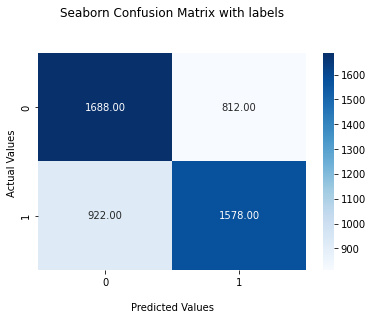

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.heatmap(confusion_matrix(Y_test, preds), annot=True, fmt='.2f', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Display the visualization of the Confusion Matrix.
plt.show()